In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline                                           
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel, RFE #SequentialFeatureSelector
from sklearn.base import clone
from sklearn import tree
%run -i '../../../../../../utils.py'

# Get data

In [7]:
# read meta data
df_meta = pd.read_csv('../../../../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin'] # only for inulin group
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance
df_bac = pd.read_csv('../../../../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# Run RandomForest

In [35]:
# parameters to run model training
method = 'selectfrommodel' # selectfrommodel or sequentialfeatureselector, or rfe
n_features_to_select = 3 # number of features to be kept

# model training
lines = []
for scfa in ['Acetate','Propionate','Butyrate']:
    for vendor_to_exclude in ['Beijing','Guangdong','Hunan','Shanghai']:
        print(scfa, vendor_to_exclude)
        
        # split train/test data
        mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
        samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
        mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
        samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))
        
        # get X and Y data
        xdata_train = np.asarray(df_bac.loc[samples_to_keep].values)
        xdata_test = np.asarray(df_bac.loc[samples_to_exclude].values)
        ydata_train = np.asarray(df_scfa.loc[samples_to_keep, scfa])
        ydata_test = np.asarray(df_scfa.loc[samples_to_exclude, scfa])

        n_features = xdata_train.shape[1]
        max_features = ['auto','sqrt','log2', 0.1, 0.2, 0.5]
        
        # make pipeline
        clf = RandomForestRegressor(n_estimators=2000, random_state=0, oob_score=True, max_depth=5)
        if method=='selectfrommodel':
            pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, max_features=n_features_to_select, threshold=-np.inf), clone(clf))  
        if method=='sequentialfeatureselector':
            pipe = make_pipeline(StandardScaler(), SequentialFeatureSelector(clf, n_features_to_select=n_features_to_select, direction='forward', scoring='r2', cv=5, n_jobs=-1), clone(clf))  
        if method=='rfe':
            pipe = make_pipeline(StandardScaler(), RFE(clf, step=10, n_features_to_select=n_features_to_select, verbose=2), clone(clf))
        random_grid = {'%s__estimator__max_features'%(method): max_features,
                       'randomforestregressor__max_features': max_features
                      }
        rf_pipe = GridSearchCV(estimator=pipe, param_grid=random_grid, cv=5, verbose=2, n_jobs=-1, scoring='r2')
        rf_pipe.fit(xdata_train, ydata_train)
        
        # predict training set
        ydata_train_predicted = rf_pipe.predict(xdata_train)
        ydata_test_predicted = rf_pipe.predict(xdata_test)
        assert 0

        for sample_, obs_, pred_ in zip(samples_to_keep, ydata_train, ydata_train_predicted):
            lines.append([scfa, vendor_to_exclude, 'train', sample_, obs_, pred_])
        for sample_, obs_, pred_ in zip(samples_to_exclude, ydata_test, ydata_test_predicted):
            lines.append([scfa, vendor_to_exclude, 'test', sample_, obs_, pred_])

df_pred = pd.DataFrame(lines, columns=['SCFA','Permutation','PredictionType','SampleID','ObservedValue','PredictedValue'])
df_pred.to_csv('rf_prediction_extrapolation_maxfeature%d_%s.csv'%(n_features_to_select, method))

Acetate Beijing
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 10.7min finished


AssertionError: 

In [39]:
rf_pipe.best_estimator_[2].oob_score_

0.2726621239260373

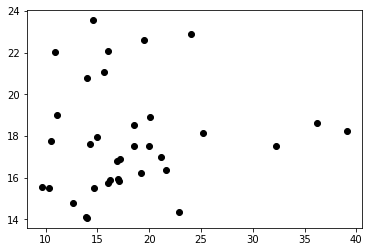

In [33]:
plt.plot(ydata_test, ydata_test_predicted, 'ko')

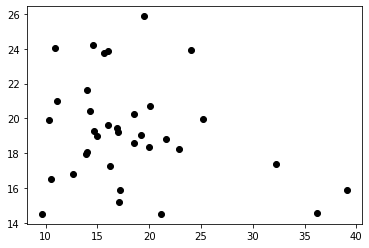

In [38]:
plt.plot(ydata_test, ydata_test_predicted, 'ko')